# Burton's Geomagnetic Storm Model

This notebook will be an implementation of the algorithm outlined by [Rande Burton](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/JA080i031p04204) on the prediction of Dst from solar wind parameters as provided by the OMNI dataset.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from helper_functions import *

## Load Data

Firstly, I'll need the OMNI data, since Burton's model depends entirely on the following measurements of solar wind data:

- V: velocity (magnitude)
- n: proton density
- $B_z$: north-south component of the interplanetary magnetic field (IMF)

Since I'm not dependent on continuous time series to the extent that I am with training predictive networks, I'll use the data with gaps and just ignore the gaps.

In [2]:
omni = pd.read_hdf('omni_hourly_1998-2018.h5')

# let's only keep the following columns
omni = omni[['SW Plasma Speed, km/s', 'BZ, nT (GSM)','SW Proton Density, N/cm^3', 'Dst-index, nT']]

# list gaps by year for each variable and total at end
nanvals = np.max(omni,axis=0)

# replace nanval for Dst, no missing data there
nanvals['Dst-index, nT'] = 999.9

# compute gap free indices
idx = np.ones(len(omni), dtype=bool)
for ii, meas in enumerate(list(omni)):
    idx = idx & (omni[meas] != nanvals[meas])

# ignore gaps here
omni = omni[idx]

V = omni['SW Plasma Speed, km/s'].values
Bz = omni['BZ, nT (GSM)'].values
n = omni['SW Proton Density, N/cm^3'].values
Dst = omni['Dst-index, nT'].values

## Theory

From the primary measurements, Burton defines the electric field $E = V\,B_z$ and the dynamic pressure $P = n\, V^2$.

In [3]:
E = V * Bz * 1e-3
P = n * V**2 * 1e-2

Dst is defined as the difference between the disturbance and quiet time measurements of the horizontal field component at low latitudes:

$$ Dst = \overline{H^d - H^q} $$

Burton furthermore models Dst in terms of its components from the magnetopause and ring currents, which have both disturbance and quiet time components:

$$ Dst = \overline{H^d_{mp}} + \overline{H^d_{rc}} -\overline{H^q_{mp}} - \overline{H^q_{rc}} $$

After introducing this separation in sources, Burton then renames the ring current contribution to Dst as $Dst_0 = \overline{H^d_{rc}}$ and posits that the quiet time contributions can be modeled as a constant $ c = \overline{H^q_{mp}} + \overline{H^q_{rc}}$. Finally, the magnetopause current contribution to Dst is proportional to square root of the dynamic pressure of the solar wind (see his citations), $\overline{H^d_{mp}} = b\,\sqrt{P}$.

Thus, the relation for $Dst_0$ can be rewritten as 

$$ Dst_0 = Dst - b\,\sqrt{P} + c$$

Since $Dst_0$ is then tied to the ring current contribution, if we can model its physical relationship to the solar wind, we can reconstruct Dst entirely from solar wind measurements (assuming that we've constrained the necessary constants).

Burton argues that the ring current contribution to Dst then depends on an injection term $F(E)$ dependent on the generated electric field that drives the main phase of the storm and subsequent decay, which in turn is proportional to the current ring current strength (setting up an exponential decay):

$$ \frac{d Dst_0}{dt} = F(E) - a\,Dst_0 $$

Thus, rewriting everything in terms of $Dst_0$, we can write the total time rate of change of Dst as 

$$ \frac{d Dst}{dt} = -a \left(Dst - b\,\sqrt{P} + c \right) + F(E) + \frac{d}{dt}\left(b\,\sqrt{P}\right) $$

An appropriate time delay must be introduced to account for the distance between where solar wind parameters are measured and Earth's surface, but the OMNI data already account for this separation.

## Parameter Estimation

Thus, the next step in forecasting Dst is determining the corresponding constants $a$, $b$, and $c$ as well as the ring current forcing $F(E)$ which will depend on the generated electric field filtered by some unknown frequency response $H(\omega)$.

Burton proceeds by considering the asymptotics of the above equation, arriving at the following values that they use for the constants:

- $a = -0.13$
- $b = 0.20 $
- $c = 20 $

I will try to recreate some of these estimates to see if they vary at all given that I have access to data gathered 40 years after the publication of their paper.


### Sudden Commencement

The first avenue via which Burton attempts to estimate the constant $b$ is to analyze Dst during sudden commencements of storms, during which time the equation $\frac{d\,Dst}{dt} \approx b\,\frac{d\,\sqrt{P}}{dt} $, so we can estimate $b$ as 

$$ b \approx \frac{\Delta\,Dst}{\Delta\,\sqrt{P}} $$

Now I need to isolate sudden commencements and compute these differences to see if the $b$ I arrive at is similar to the values of 0.14-0.43 listed by Burton. This seems to be sort of a difficult task, since I'll have to likely find all of the sudden commencements by hand. Also, commencements are often on the order of minutes, while the OMNI data are hourly. Thus, I'll save this estimation for another time.

### Quiet time estimation

Here, I'll take the approach that assumes no ring current injection (i.e. $F(E) = 0$) and constant dynamic pressure (i.e. $\frac{dP}{dt} = 0 $), so that the relevant equation is 

$$ \frac{d Dst}{dt} = -a \, \left(Dst - b\,\sqrt{P} + c \right) $$

This expression will asymptotically approach zero, and so eventually Dst will approach the value satisfying 

$$ Dst - b\,\sqrt{P} + c = 0$$

allowing us to solve for $b$ and $c$. This expression is true during quiet times, which we can isolate from the data above.

In [4]:
# isolate data from quiet times
storm_idx = findstorm(Dst, -35, nhr_before=100, nhr_after=500)
quiet_idx = np.logical_not(convertidx(storm_idx, len(Dst)))
#q_idx = (Dst < 40) & (Dst > -30)
Dst_q = Dst[quiet_idx]
P_q = P[quiet_idx]

b = 0.078, c = 9.88


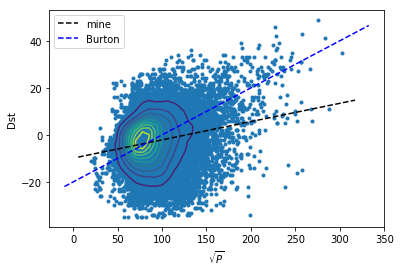

In [5]:
# set up linear system
tar = Dst_q
des = np.concatenate((np.sqrt(P_q).reshape(-1,1), \
                     -np.ones((np.sum(quiet_idx),1))), axis=1)

# invert
out = np.matmul(np.matmul(np.linalg.inv(np.matmul(des.T, des)), des.T), tar)

print('b = %1.3f, c = %1.2f' % (out[0], out[1]))

# plot
plt.scatter(np.sqrt(P_q), Dst_q, marker='.')
plotcontours(np.sqrt(P_q).reshape(-1,1), Dst_q.reshape(-1,1), nbins=40)
l1 = abline(out[0], -out[1])
l2 = abline(0.2, -20)
l2.set_color('blue')
plt.xlabel('$\sqrt{P}$')
plt.ylabel('Dst')
plt.legend(('mine', 'Burton'))
plt.show()

The values above are sort of close to the value of $b = 0.2$-$0.4$ and $c = 20$ that Burton et al. use in their study. From the figure, it's also clear that Burton's values could fit a subpopulation of the data that do seem to have the corresponding trend, while my least squares fit is sensitive to a cluster of data with lower Dst values.

Burton then uses these coefficient values to compute $Dst_0$, from which it is possible to compute the coefficient $a$ from $\frac{dDst_0}{dt} = -a\,Dst_0$, assuming no ring current injection. This assumption holds during the recovery phase after the main phase of the storms, which I isolate below.

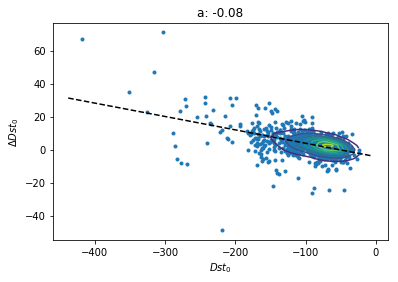

In [7]:
b = 0.20
c = 20

# indices of recovery phase
r_idx = findstorm(Dst, -150, nhr_before=-8, nhr_after=40)

# compute Dst0
Dst0 = Dst - b*np.sqrt(P) + c

nstorm = r_idx.shape[0]
npoint = np.diff(r_idx, axis=1)[0][0]

# for each storm, compute difference in Dst0
dDst0 = np.zeros((nstorm, npoint-1))
Dst0_prev = np.zeros((nstorm, npoint-1))
for ii in range(nstorm):
    dDst0[ii,:] = Dst0[r_idx[ii,0]+1:r_idx[ii,1]] - \
                  Dst0[r_idx[ii,0]:r_idx[ii,1]-1]
    Dst0_prev[ii,:] = Dst0[r_idx[ii,0]:r_idx[ii,1]-1]
    
# fit slope to points and plot
p = np.polyfit(Dst0_prev.reshape(-1), dDst0.reshape(-1), 1)

plt.scatter(Dst0_prev.reshape(-1), dDst0.reshape(-1), marker='.')
plotcontours(Dst0_prev.reshape(-1,1), dDst0.reshape(-1,1))
abline(p[0], p[1])

plt.xlabel('$Dst_0$')
plt.ylabel('$\Delta Dst_0$')
plt.title('a: %1.2f' % p[0])
plt.show()

The value for $a$ that I compute above is less than the value of $a=-0.13$ that Burton proposes.

### F(E)

The next step for Burton was to estimate the ring current injection $F(E)$ as a function of the electric field induced by the solar wind magnetic field. 

#### Time lag

Burton begins by computing the time lag between changes in the E field at the nose of the magnetosphere and the corresponding change in Dst. Computing this lag, however, requires isolating times of large change in the electric field when the dynamic pressure is not also changing.

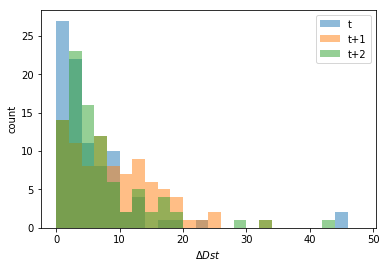

In [8]:
stableP_idx = np.abs(np.diff(P)) < 500
changeE_idx = np.abs(np.diff(E)) > 4

idx = np.where(np.logical_and(stableP_idx, changeE_idx))[0]

# now plot changes in Dst with respect to differences in timing of change in E
t1 = np.zeros(len(idx))
t2 = np.zeros(len(idx))
t3 = np.zeros(len(idx))
for ii in range(len(idx)):
    t1[ii] = np.abs(Dst[idx[ii]+1]-Dst[idx[ii]])
    t2[ii] = np.abs(Dst[idx[ii]+2]-Dst[idx[ii]+1])
    t3[ii] = np.abs(Dst[idx[ii]+3]-Dst[idx[ii]+2])
    
plt.figure()
bins = np.arange(0, 50, 2)
plt.hist(t1, bins, alpha=0.5, label='t')
plt.hist(t2, bins, alpha=0.5, label='t+1')
plt.hist(t3, bins, alpha=0.5, label='t+2')
plt.legend()
plt.xlabel('$\Delta Dst$')
plt.ylabel('count')
plt.show()

The above figure shows that the largest changes in Dst tend to occur one hour after the largest changes in the induced electric field, supporting the interpretation that the time delay is on the order of an hour. 

Burton uses a value of 25 minutes, which we are unable to assess due to the spacing of the OMNI data.

#### Injection Rate Determination

From the following equation

$$ \frac{d Dst}{dt} = -a \left(Dst - b\,\sqrt{P^\prime} + c \right) + F(E^\prime) + \frac{d}{dt}\left(b\,\sqrt{P^\prime}\right) $$

we can determine $F(E)$ by isolating intervals with no change in dynamic pressure (i.e. $\frac{d\,P^\prime}{dt}=0$) as

$$ \frac{d Dst}{dt} + a \left(Dst - b\,\sqrt{P^\prime} + c \right) = F(E^\prime)$$

Text(0, 0.5, 'ring current injection')

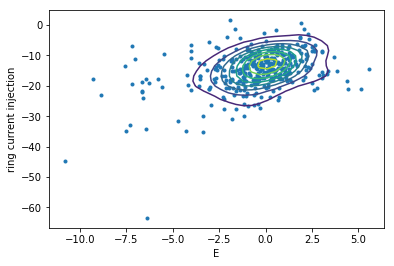

In [10]:
b = 0.9
c = 10
a = 0.13

# get indices of unchanging dynamic pressure
stableP_idx = np.abs(np.diff(P)) < 200

# get storm indices
storm_idx = findstorm(Dst, -100, nhr_before=0, nhr_after=36)
storm_idx = convertidx(storm_idx, len(Dst))
storm_idx = storm_idx[0:-1]

idx = np.logical_and(stableP_idx, storm_idx)

dDst = np.diff(Dst)[idx]

P_tmp = P[0:-1][idx]
Dst_tmp = Dst[0:-1][idx]

F = dDst + a*(Dst_tmp - b*np.sqrt(P_tmp) + c)
E_tmp = E[0:-1][idx]

plt.scatter(E_tmp, F, marker='.')
plotcontours(E_tmp.reshape(-1,1), F.reshape(-1,1), nbins=40)

plt.xlabel('E')
plt.ylabel('ring current injection')

The results above do not at all align with the results presented by Burton, who apparently actually measured ring current injection rates. He claims that for $E<0$, the injection rate is zero, while for $E > 0$ the injection rate is linear. 

## Evaluation

In [25]:
# keep in units of per hour
a = 0.13
b = 0.2
c = 20
d = -1.5e-3 * 60

In [48]:
F = np.zeros(len(Dst))
idx = E > 0.5
F[idx] = d*(E[idx] - 0.5)

Dst_new = Dst[1:-1] - a*(Dst[1:-1] - b*np.sqrt(P[1:-1]) + c) + F[1:-1] + b*(np.sqrt(P[1:-1])-np.sqrt(P[0:-2]))

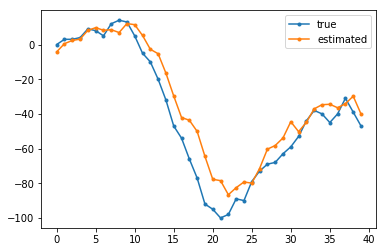

In [49]:
plt.plot(Dst[1130:1170], '.-')
plt.plot(Dst_new[1128:1168], '.-')

plt.legend(('true','estimated'))